In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

In [2]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
execfile("AE_RIM_definitions.py")

train_batch_size = 10
npix_side = 512

# checkpoint_path_1 = "checkpoints/model1_512"
# checkpoint_path_2 = "checkpoints/model2_512"


import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

In [20]:
src_side = 20.48/2
im_side = 20.48

sk_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,kap_side_length=im_side, num_src_side=npix_side,num_kappa_side=npix_side,src_side=src_side)
lens_util_obj = lens_util(im_side= im_side, src_side=src_side, numpix_side = npix_side ,kap_side=im_side,  method = "Unet")


noise_rms = 0.01
sk_gen.draw_k_s("test")

# RESTORE=False
# if (RESTORE):
#     RIM.model_1.load_weights(checkpoint_path_1)
#     RIM.model_2.load_weights(checkpoint_path_2)

In [21]:
VAE_obj_master = VAE(n_latent = 64 , npix_side = npix_side)
VAE_obj_learner = VAE(n_latent = 64 , npix_side = npix_side , output_activation='linear')
master_checkpoint_path = "checkpoints/model_VAE_512"
learner_checkpoint_path = "checkpoints/model_VAE_512_not_normalized"
RESTORE = True
if (RESTORE==True):
    VAE_obj_master.load_weights(master_checkpoint_path)
    VAE_obj_learner.load_weights(learner_checkpoint_path)

In [22]:
VAE_SRC_obj = VAE(n_latent = 64 , npix_side = npix_side)
load_VAE_SRC_checkpoint_path = "checkpoints/model_VAE_512_SRC"
RESTORE = True
if (RESTORE==True):
    VAE_SRC_obj.load_weights(load_VAE_SRC_checkpoint_path)

In [23]:
FFCNN_obj = FFCNN(load_checkpoint_path = "checkpoints/FFCNN_VAE_VAESRC_weights" , save_checkpoint_path = "checkpoints/FFCNN_VAE_VAESRC_weights" , AUTOENCODER_obj=VAE_obj_learner )
FFCNN_obj.Load()

In [24]:
optimizer = tf.train.AdamOptimizer(4e-5)

In [25]:
# sk_gen.draw_k_s("train")
# tf_source =  tf.identity(sk_gen.Source_tr[:,:,:,:])
# tf_logkappa  = tf.identity( np.log10(sk_gen.Kappa_tr[:,:,:,:] ) ) 
# noisy_data = lens_util_obj.simulate_noisy_lensed_image(  tf_source, tf_logkappa ,noise_rms)

# pl.clf()
# fig, ax = pl.subplots(1, 1, figsize = (10, 10))
# pl.subplots_adjust(wspace = 0, hspace = 0)
# imsrcT = ax.imshow(noisy_data[0,:,:,0].numpy())

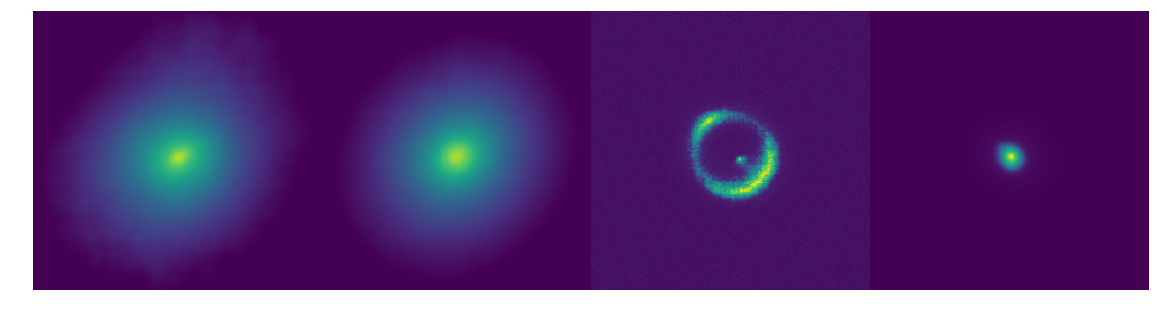

saved
200
201
202
203
204
205
206
207
208


KeyboardInterrupt: 

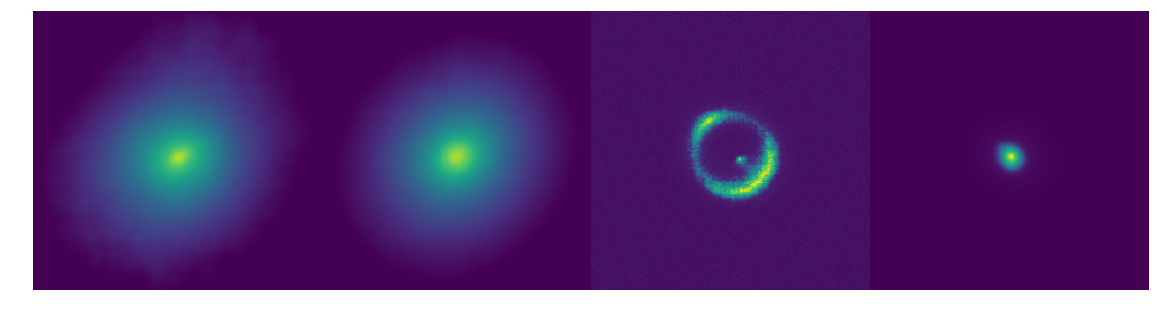

In [28]:
for train_iter in range(10000):
    print train_iter
    #sk_gen.draw_k_s("train")

    normalizations = tf.tile(tf.random_uniform(shape=[train_batch_size,1,1],minval=2.9, maxval=3.2),(1,npix_side,npix_side))
    tf_logkappa = tf.reshape(tf.log(normalizations * VAE_obj_master.draw_image(train_batch_size)) , (-1,npix_side,npix_side,1) )
    #tf_logkappa = tf.reshape(log10(VAE_obj_learner.draw_image(train_batch_size)) , (-1,npix_side,npix_side,1) )

    
    #tf_source =  tf.identity(sk_gen.Source_tr[:,:,:,:])
    tf_source = tf.reshape(VAE_SRC_obj.draw_image(train_batch_size),(-1,512,512,1))
    #tf_logkappa  = tf.identity( np.log10(sk_gen.Kappa_tr[:,:,:,:] ) ) 
    noisy_data , tf_source = lens_util_obj.simulate_noisy_lensed_image(  tf_source, tf_logkappa ,noise_rms)

    FFCNN_obj.train( noisy_data , tf_logkappa, optimizer)

    if (((train_iter+1)%10)==0):
        output =  FFCNN_obj.fullforward_pass(noisy_data)
        #logkappa_first_guess = np.log(10)* (tf.reshape(FFCNN_obj.fullforward_pass(noisy_data) , (-1,npix_side,npix_side,1) ) )
        pl.clf()
        fig, ax = pl.subplots(1, 4, figsize = (20, 40))
        pl.subplots_adjust(wspace = 0, hspace = 0)
        imsrcP = ax[0].imshow(tf_logkappa[0,:,:,0],vmin=-2.0 , vmax=1.5)

        imsrcT = ax[1].imshow(output[0,:,:].numpy(),vmin=-2.0 , vmax=1.5)
        imsrcT = ax[2].imshow(noisy_data[0,:,:,0].numpy())
        imsrcT = ax[3].imshow(tf_source[0,:,:,0].numpy())        
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')
        display.clear_output(wait=True)
        display.display(pl.gcf())
    if (((train_iter+1)%100)==0):
        FFCNN_obj.Save()
        print "saved"





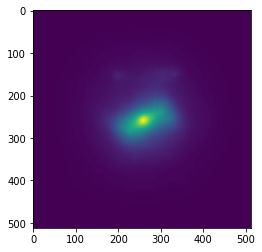

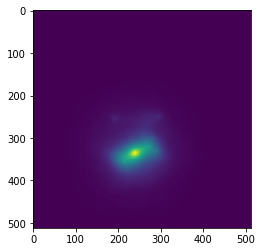

In [79]:
scaling = np.random.uniform(low=0.4, high=0.8)
xrandshift = np.random.normal(loc=0.0, scale=100.0)
yrandshift = np.random.normal(loc=0.0, scale=100.0)

xshift =  (512/2-(1/scaling * 512/2)) + xrandshift
yshift =  (512/2-(1/scaling * 512/2)) + yrandshift
im_transformed = tf.contrib.image.transform(tf_source,   [1/scaling,0, xshift ,0,1/scaling,yshift,0.,0.])
pl.imshow(tf_source[0,:,:,0])
pl.figure()
pl.imshow(im_transformed[0,:,:,0])

In [61]:
-(512/2-(1/scaling * 512/2))

768.0